# TL;DR

We applied a probilistic machine learing approach to a dataset of hitchhiking waiting times around the world.
In comparison to previous endeavors we are able to make waiting time predictions for any spot on the globe that results in a complete world map that is also more accurate than previous partial maps despite our chosen performance metric and experienced hitchhikers. In addition we are able to model uncertainties of waiting time predictions to not pretend that our predictions are accurate where there is no evidence and to call hitchhikers to share their experience especially in the regions where we lack data till this day.

To achieve this we applied a Gaussian process on data points in a 2D feature space (longitude, latitude) and quite noisy target values (waiting times). Specifically we made use of a kernel that involves three radial basis function kernels that each model a different scale on which waiting times in hitchhiking depend on each other. Besides that we built the model so that its predictions are inherently constrained to positive waiting times. Eventually we demonstrated how domain expertise can be used to tune the models hyperparameters.

The GP-kernel we applied would look as follows for 1-dimensional inputs:

$$k_{3\_RBFs}(x, x') = \sum_{i \in \{a, b, c\}}{\sigma_i}^2 \exp(- \frac{(x - x')^2}{2 l_i^2}) + \sigma_n \mathbb{I}(x = x')$$

The data challenges we had to face and migth be transferable to other GP problems:
- extremely noisy target values
- target values are not normally distributed and constrained to be greater than 0
- 2D feature-space
- varying density of data in the feature-space that prohibits the use of a simple RBF kernel

Our work resulted in a model that enabled us to draw the following map where a region becomes more grayed out if the model is more uncertain about how long a hitchhiker would wait in that region.

![World map](maps/best_map.png)

You can find the original [notebook](https://github.com/Hitchwiki/hitchmap-data/blob/main/visualization/predictors/heatchmap.ipynb) and helper code [here](https://github.com/Hitchwiki/hitchmap-data/tree/main/visualization/predictors).

# Applying Gaussian process models to predict world-wide hitchhiking waiting times

In [1]:
from utils_imports import *

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**What do we want to achieve?**

A world map of estimated hitchhiking waiting times! For this purpose, we have to develop a predictive model that estimates the waiting time for hitchhiking at any location given the waiting times that were recorded on https://hitchmap.com/ since 2005 (most extensively from 2010 to 2016). For the following we are using the hitchwiki dump from 04/11/2024.

The map should be visually appealing. By that we mean that changes in the waiting time should not be too drastic and it should look organic in the way that there are no hard straight edges visible.

We are quantifying the quality of the map by the average deviation of the predicted waiting time from the actual waiting time. As the the problem at hand is a regression problem, this evaluation metric is referred to as mean absolute error (MAE). The rational behind this choice is that the MAE is easy to interpret and that we are dealing with extremely noisy data (ther is measurement noise for each data point especially for longer waiting times and there are outliers in the data caused by (bad) luck on the road) thus we want to avoid that the model gets punished too much by outliers as a root mean squared error (RMSE) would do. Still we are reporting the RMSE as well to give a more complete picture of the model performance.

Finally we want to build a model in which we can build in knowledge about hitchhiking in general but not about the the underlying world map. This importantly involves not building a sub-model for each region from a set of predefined regions as this process would be too manual, teadious and subjective.

**Which assuptions do we make?**

We assume that hitchhiking success in a certain spot depends mostly on the density of the traffic and the attitude of the drivers. In this work we focus a little more on the latter assuming that cultural differences mostly determine how quickly one is picked up on the road.

Throughout this notebook we are using [a metric coordinate system](https://epsg.io/3857) which enables us to measure distances between spots in a convenient way.

# Getting started with simple models

To get a feeling for the models we are viewing a 1D-example first. To achieve this we are only using data points with roughly the same latitude value.
Specifically we are cutting horizontally through Germany at 51° latitude (roughly from Aachen to Görlitz), collecting all points that lie within a 10km strip around this cut and project them to 51° latitude.

Here we want to introduce the models that we will compare across all following experiments.

- As a minimal benchmark we use model that always predicts the average waiting time - calling it AVERAGE.
- Getting just a little more complex we are dividing the world into same-sized tiles and predict the average of all points in one tile for all locations that lie in that tile - calling it TILES.
- As proposed by the [single existing hitchhiking heatmap](https://abelblogja.wordpress.com/average-waiting-times-in-europe/) that is around since 2019 we assume that each recorded waiting time gives us some certainty that it is the correct approximated waiting time in the region around it. The decrease in certainty or the area a single point influences is modelled by a bivariate normal distribution (2D Gaussian) with its mean at the point and a standard deviation of e.g. 50 km. To make a prediction at a new point the waiting times from all known points are weighted by the value of their Gaussian at the new point and then averaged by the total number of points - calling it WEIGHTED AVERAGED GAUSSIANS (not quite happy with the naming - open for suggestions). Although such a model can create quite visully appealing maps for small regions with a lot of data it has a few shortcomings when trying to apply it to a world map. In regions with few data hard edges between and circles around data points occur. Those effects are caused by the tailes of the Gaussian and the precision of numbers we can store and can be observed further below. We tried some approaches to mitigate those effects here (namely dynamically setting the size of the circle each data point influences and iteratively increasing the circel-size around each point to fill the parts of the map where no prediction was possible before) but could not yield satisfactory results.
- Eventually we apply a Gaussian process (GP) model that we will focus on and train in the following.

In the following we will compare the GP to the other models to develop a first understanding of it and make first improvements to the model.



In [2]:
points, val = get_cut_through_germany()

In [3]:
wag_model = WeightedAveragedGaussian(region='germany')
wag_model.fit(points[['lon', 'lat']].values, points['wait'])
evaluate(wag_model, train=points, validation=val, features=['lon', 'lat'])

Training RMSE: 24.050772731007733
Training MAE 14.492408587081854
Validation RMSE: 29.202554515406614
Validation MAE 19.08422522014841



In [4]:
average_model = Average()
average_model.fit(points[['lon', 'lat']].values, points['wait'])
evaluate(average_model, train=points, validation=val, features=['lon', 'lat'])

Training RMSE: 28.883930945852764
Training MAE 18.240333135038668
Validation RMSE: 26.11086058835615
Validation MAE 16.88917924893535



In [5]:
tiles_model = Tiles(region='germany')
tiles_model.fit(points[['lon', 'lat']].values, points['wait'])
evaluate(tiles_model, train=points, validation=val, features=['lon', 'lat'])

Training RMSE: 26.542649855998334
Training MAE 15.744948589191775
Validation RMSE: 28.242465745522914
Validation MAE 16.93535247432306



In [6]:
X = points[["lon"]].values
y = points["wait"].values

# as the target values are normalized in our model the standard deviation is 1
# this is a good estimate for the sigma parameter consequently it should lie somewhere close to it
sigma = 1.0

# parameter bounds are set to constrain the hyperparameters to reasonable values
rbf = RBF(length_scale_bounds=(1e4, 3e5))
# the ConstantKernel represents the factor in front of the RBF kernel
kernel = ConstantKernel(
    constant_value=sigma**2, constant_value_bounds=(1e-1, 1e1)
) * rbf + WhiteKernel(noise_level_bounds=(4e-1, 1e0))

gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,  # the WhiteKernel represents the data noise already
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=True,  # as the GP assumes 0 mean target values, but waiting times are not 0 mean yet
    n_restarts_optimizer=0,
    random_state=42,
)

# we log-transform the target values for training and back-transform during prediction as the original waiting times rather follow a log-normal distribution
# than a normal distribution that is assumed by the GP
# mind that the transformation function has to be defined for 0 target values
target_transform_gpr = TransformedTargetRegressorWithUncertainty(
    regressor=gpr, numeric_transformer=MyLogTransformer()
)

target_transform_gpr.fit(X, y)
evaluate(target_transform_gpr, train=points, validation=val, features=['lon'])
print(target_transform_gpr.regressor_.kernel_)

Training RMSE: 26.687392851982803
Training MAE 13.312233135316987
Validation RMSE: 27.842342542498827
Validation MAE 16.860716426605116

0.498**2 * RBF(length_scale=7e+04) + WhiteKernel(noise_level=0.729)


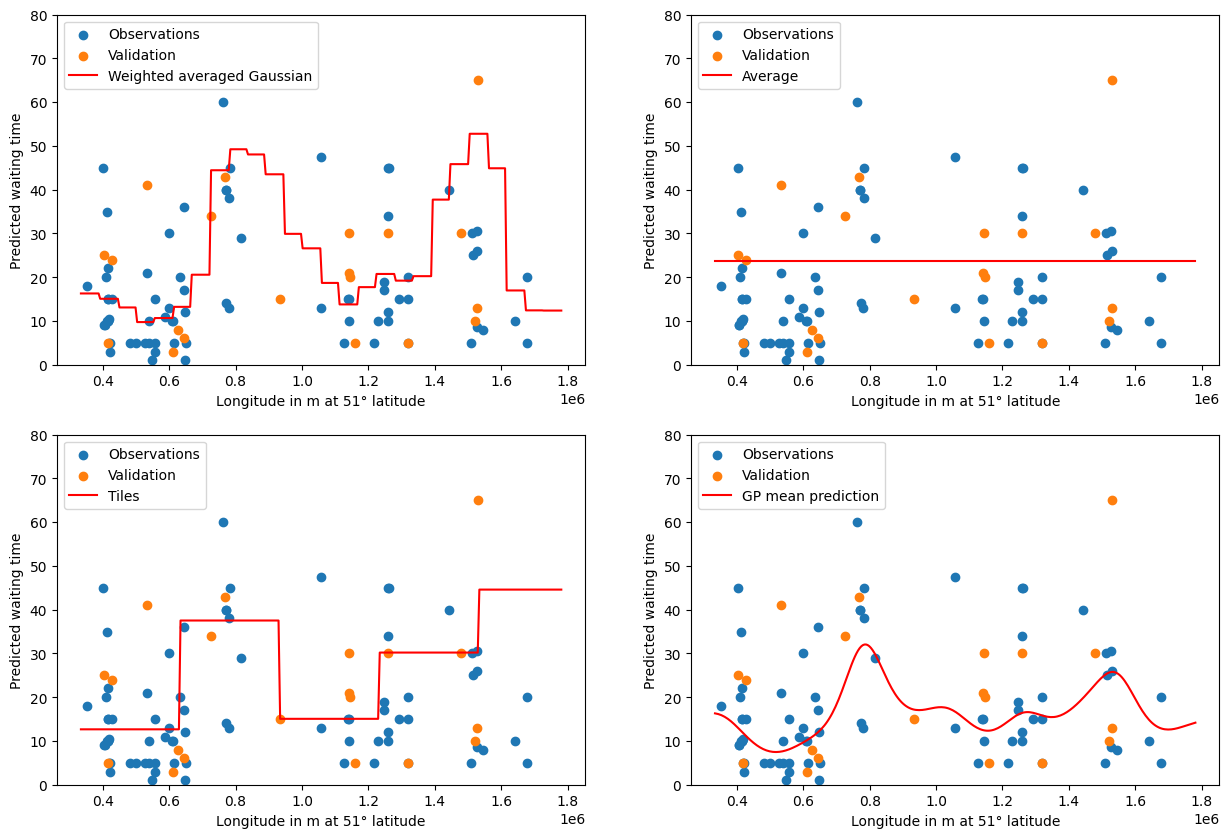

In [7]:
plot_1d_model_comparison(points, val, X, y, wag_model, average_model, tiles_model, target_transform_gpr)

With a first intuition for each of the models we want to take a look at some of the model choices in the Gaussian process.

The first thing to note is the transformation of the target values (waiting times). For GPs we can and have to specify our assumptions about the kinds of fuctions that can be leared from the data. These are called the prior. In general the prior assumes a 0-mean for the data and that the data points are normally distributed around this mean. It is obvious that waiting times have to be above 0 and are thus [constrained](https://www.osti.gov/servlets/purl/1847480/) which implies that the original data cannot be normally distributed.

To address this in our model we are applying a [log-transformation](https://github.com/dfm/george/issues/106) to the waiting times and centering these transformed target values around 0. This removes the constraint on the waiting times as it maps positive real numbers to all real numbers. The log-transformation most importantly prevents the function that will be predicted by our GP model to drop below 0 which might otherwise occur especially when assuming that the waiting times can deviate a lot from the mean and there is lot of noise in the data.

We can take a look how the target values look like after being transformed.

Keep in mind the when feeding transformed targets into our GP model we will have to invert the transformation when making predictions.

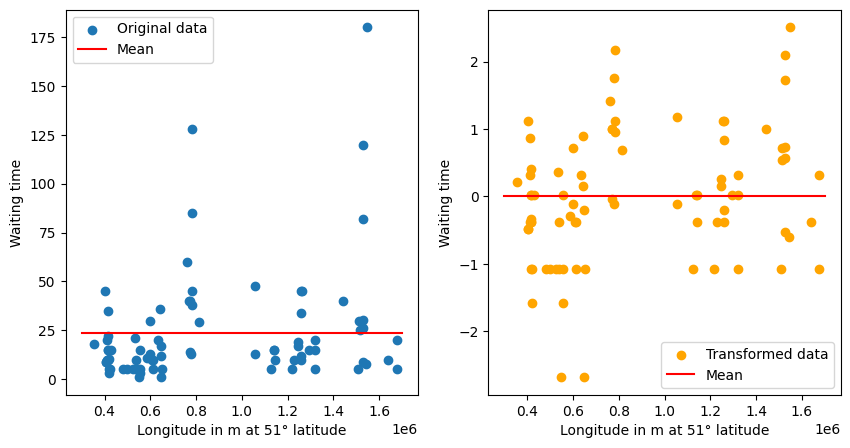

In [8]:
plot_transformed_targets(X, y)

The form of the function a GP can predict is most importantly determined by its kernel (or covariance) function which determines how strong waiting times are correlated depending on their relative distance to each other and thus how known waiting times influence predictions in a new spot. A common choice for a kernel is the [radial basis function kernel (RBF)](https://www.cs.toronto.edu/~duvenaud/cookbook/) which in general results in smooth predicted functions.

The specific form of a RBF is determined by a variance (determining how much the function can deviate from the mean) and a lengthscale (determining how far each point can influence the form of the function) parameter. Besides that the covariance function allows to model the noise in each data point (how accurate they are). For now we assume the same noise for each record of waiting time and get another parameter to tune. It is a good first choice for the variance parameter to set it to the variance of the training data. That is why we fix it in the following experiment. With this two hyperparameters remain that we want to set so that it results in a model that best reflects the underlying data.

Although we are evaluating on mean absolute error, what we consider a good model is determined by the log marginal likelihood that is the probability of observing the data at hand given a certain choice of parameters - also called GP evidence maximization. So this becomes the loss function we are optimizing. In comparison to direcly optimizing the MAE it is less prone to overfitting to the data.

We will first view how the parameters to tweak influence the log marginal likelihood and from that on reason about a good choice of parameter values applying what we know about hitchhiking.

Broadly we consider a lengthscale between 100m and 10'000km and a noise of 0.1 to 10 in the transformed target value space (the range for reasonable noise levels can be obtained from the above plot of the target values in the transformed space).

In [9]:
rbf = RBF(length_scale_bounds=(1e-100, 1e100))
kernel = ConstantKernel(
    constant_value=1.0**2, constant_value_bounds="fixed"
) * rbf + WhiteKernel(noise_level_bounds=(1e-100, 1e100))

gpr = get_optimized_gpr(kernel, X, y)

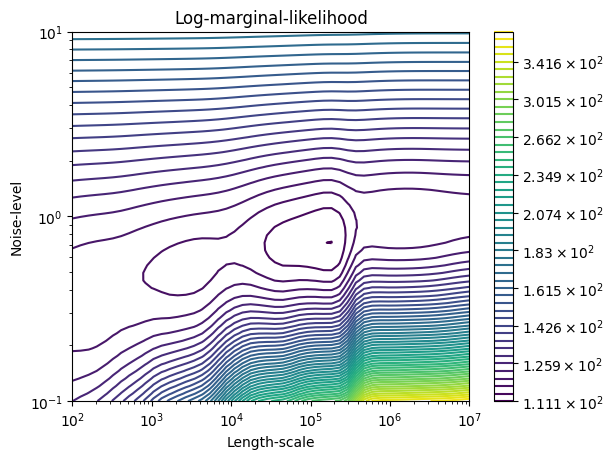

In [10]:
plot_lmm_depending_on_lengthscale_noise(gpr)

In [11]:
# local optimum
kernel = ConstantKernel(constant_value=1.0**2, constant_value_bounds="fixed") * RBF(
    length_scale_bounds=(1e3, 1e4)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))

get_optimized_gpr(kernel, X, y).regressor_.kernel_

1**2 * RBF(length_scale=3.24e+03) + WhiteKernel(noise_level=0.528)

In [12]:
# local optimum
kernel = ConstantKernel(constant_value=1.0**2, constant_value_bounds="fixed") * RBF(
    length_scale_bounds=(1e4, 1e6)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))

get_optimized_gpr(kernel, X, y).regressor_.kernel_

1**2 * RBF(length_scale=1.67e+05) + WhiteKernel(noise_level=0.732)

In [13]:
# local optimum
kernel = ConstantKernel(constant_value=1.0**2, constant_value_bounds="fixed") * RBF(
    length_scale_bounds=(1e6, 1e7)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))

get_optimized_gpr(kernel, X, y).regressor_.kernel_

1**2 * RBF(length_scale=1.51e+06) + WhiteKernel(noise_level=0.95)

In [14]:
# global optimum
kernel = ConstantKernel(constant_value=1.0**2, constant_value_bounds="fixed") * RBF(
    length_scale_bounds=(1e3, 1e7)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))

get_optimized_gpr(kernel, X, y).regressor_.kernel_

1**2 * RBF(length_scale=3.24e+03) + WhiteKernel(noise_level=0.528)

We can observe that there are three local minima for the log marginal likelihood that strongly differ in the RBF kernel lengthscale. Further analysing we can find out that the global minimun lies at a 3240m lengthscale (the left minimum) and the other local minima lie at 167km and 1510km lengthscale. One can say that the lengthscale is about the distance until which points influence each other (see the graphic below). With our hitchhiking knowledge in mind we can safely say that hitchhiking culture rather changes within a magnitude of 100km than 1000km (and certainly within 1km but that would disable us to make predictions in most locations as we have too few data) and thus decide for parameter values that result in a non-global minimum. As a consequence we are setting the bounds in which the lengthscale should lie to 10km to 1000km from now on and assume that if we find an optimal lengthscale that lies within those reasonable bounds it is the local optimum that we want to achieve.

It is interesting to not that we can observe increasing data noise for larger lengthscales due to the fact that smoother functions are less able to fit to the povided training data points.

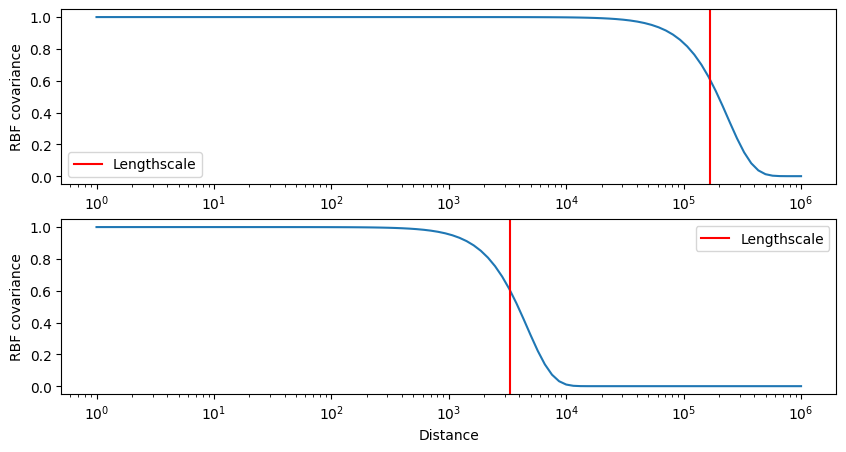

In [15]:
plot_rbf_covariance()

To close this first section we are having a first look at the uncertainties that we can retieve from the GP model. The uncertainties (manifesting in the 95% confidence intervals) are only slightly higher where we have less training data. But overall the uncertainty seems quite even - the cause for this still has to be investigated. Still the tiny differences were of use for our final map.

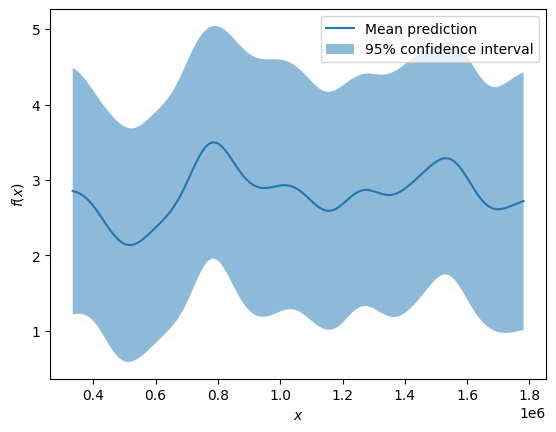

In [16]:
plot_1d_with_uncertainties(target_transform_gpr, X, y, start=tiles_model.lon_intervals[0], stop=tiles_model.lon_intervals[-1])

# Making predictions in longitude-latitude space

Now we have layed the foundation to move on to the actual problem where points are represeted by longitude (x-axis) and latitude (y-axis). With this we are faced with a 2D-version of the above problem and we can build up on the insights we have gained so far.

We will develop predictive models for Germany, Europe and eventually the whole world. The rational behind this is that more challenges will emerge the broader the map gets and the more difference we get in the density of data points. That is why we want to first look at the regions where the majority of the data concentrates. Besides that we want to make sure that the resulting predictive model is particularly precise and informative where most of the hitchhiking traffic occurs which is Europe (see map below).

Gradually we will build more and more complex models with more free hyperparameters and more complex kernel functions.

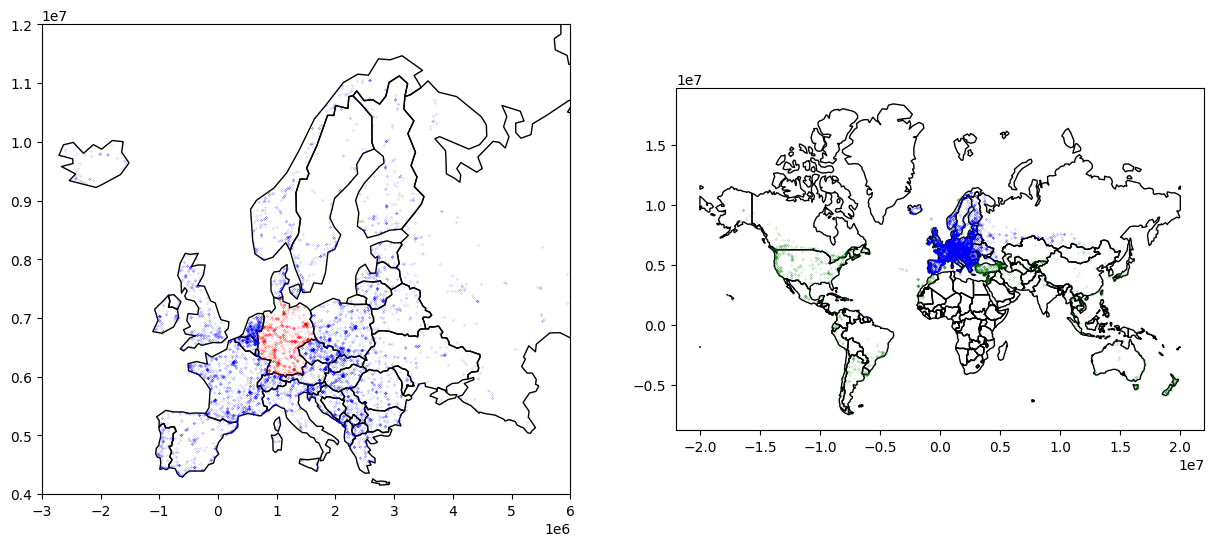

Germany: 10.75 %
Europe without Germany: 69.51 %
Rest of the world: 19.74 %


In [ ]:
plot_distribution_of_data_points()

## Country level - Germany

First we are taking a look at Germany. We consider the same four models as in the 1D example and compare their performace. From now on we will use 5-fold cross-validation if the runtime for training the model permits. For the displayed maps we are using a low resolution as prediction with GPs is costly namely $\mathcal{O}(n^2)$ if $n$ was the number of training samples.

In [ ]:
region = 'germany'
points, training, validation = get_from_region(region=region)

Cross-validated averaged metrics...
Training RMSE: 39.47403124630482
Training MAE: 22.822391431585412
Validation RMSE: 40.637551940683906
Validation MAE: 23.710596308405364



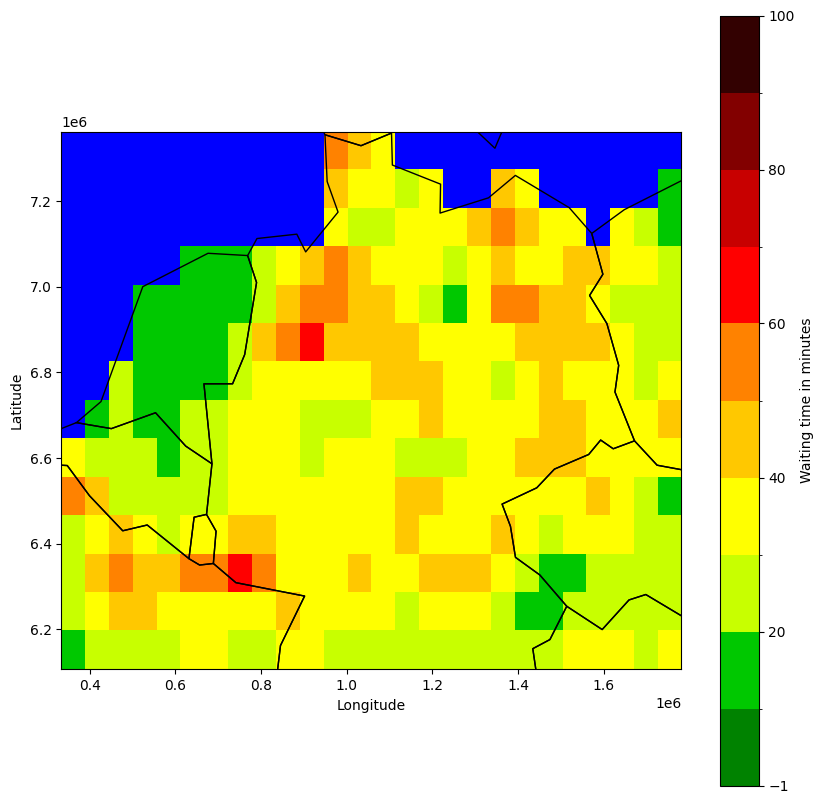

<Figure size 640x480 with 0 Axes>

In [ ]:
wag_model = WeightedAveragedGaussian(region=region)
wag_model = evaluate_cv(estimator=wag_model, X=points[["lon", "lat"]].values, y=points["wait"])
wag_model.build_map()

Cross-validated averaged metrics...
Training RMSE: 41.700716722506705
Training MAE: 24.692506681672775
Validation RMSE: 41.47687241204024
Validation MAE: 24.692529457136537



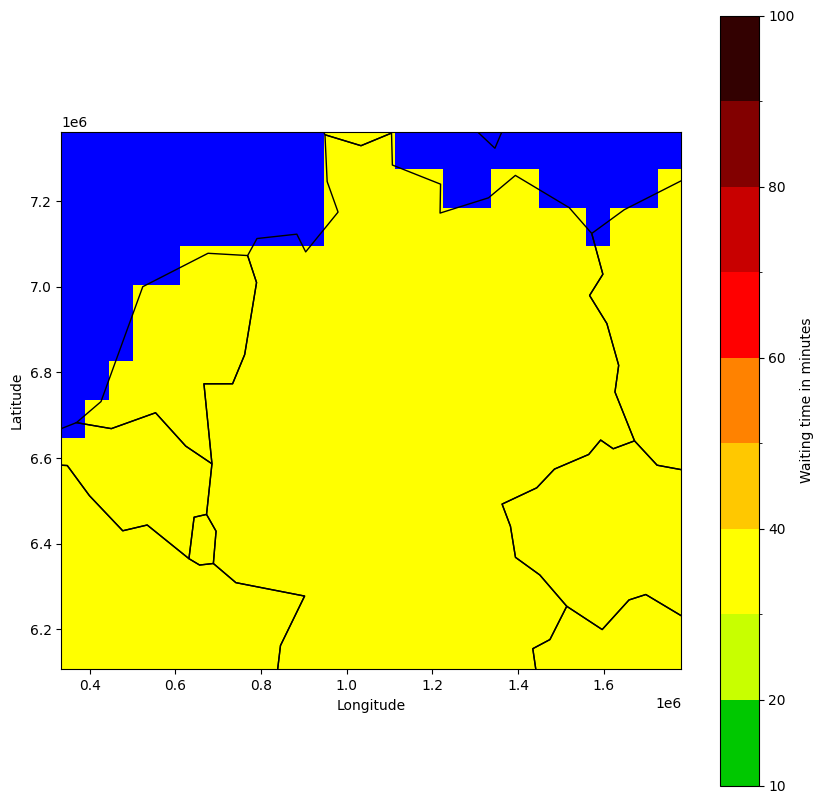

<Figure size 640x480 with 0 Axes>

In [ ]:
average_model = Average()
average_model = evaluate_cv(estimator=average_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(average_model, region=region)

Cross-validated averaged metrics...
Training RMSE: 40.993822365353665
Training MAE: 24.053454534454843
Validation RMSE: 41.15913591352587
Validation MAE: 24.329956706206097



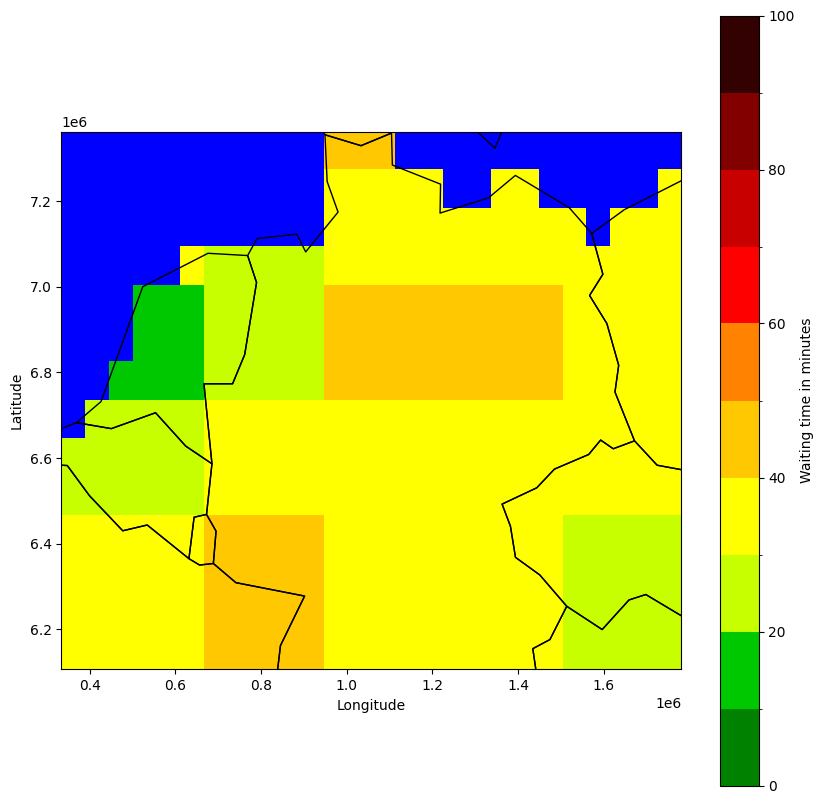

<Figure size 640x480 with 0 Axes>

In [ ]:
tiles_model = Tiles(region=region)
tiles_model = evaluate_cv(estimator=tiles_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(tiles_model, region=region)

Cross-validated averaged metrics...
Training RMSE: 42.541424394390894
Training MAE: 21.123958709243873
Validation RMSE: 42.48275278183233
Validation MAE: 21.265450570464147

1**2 * RBF(length_scale=1.75e+05) + WhiteKernel(noise_level=0.892)


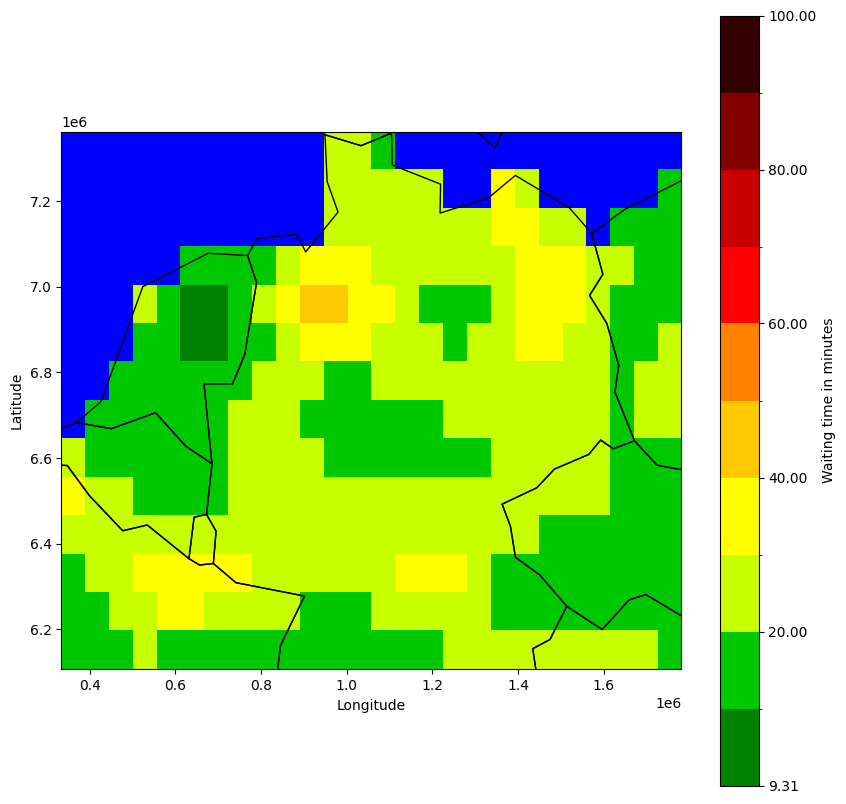

<Figure size 640x480 with 0 Axes>

In [ ]:
X = points[['lon', 'lat']].values
y = points['wait'].values

kernel = ConstantKernel(constant_value=1.0**2, constant_value_bounds='fixed') * RBF(
    length_scale_bounds=(1e4, 1e6)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


gpr = get_gpr(kernel)
gpr = evaluate_cv(estimator=gpr, X=X, y=y)
print(gpr.regressor_.kernel_)
map_from_model(gpr, region=region)

## Continet level - Europe

In [ ]:
region = 'europe'
points, training, validation = get_from_region(region=region)

Cross-validated averaged metrics...
Training RMSE: 55.89760792537104
Training MAE: 27.764498657377846
Validation RMSE: 62.05487069918561
Validation MAE: 30.40815983400363



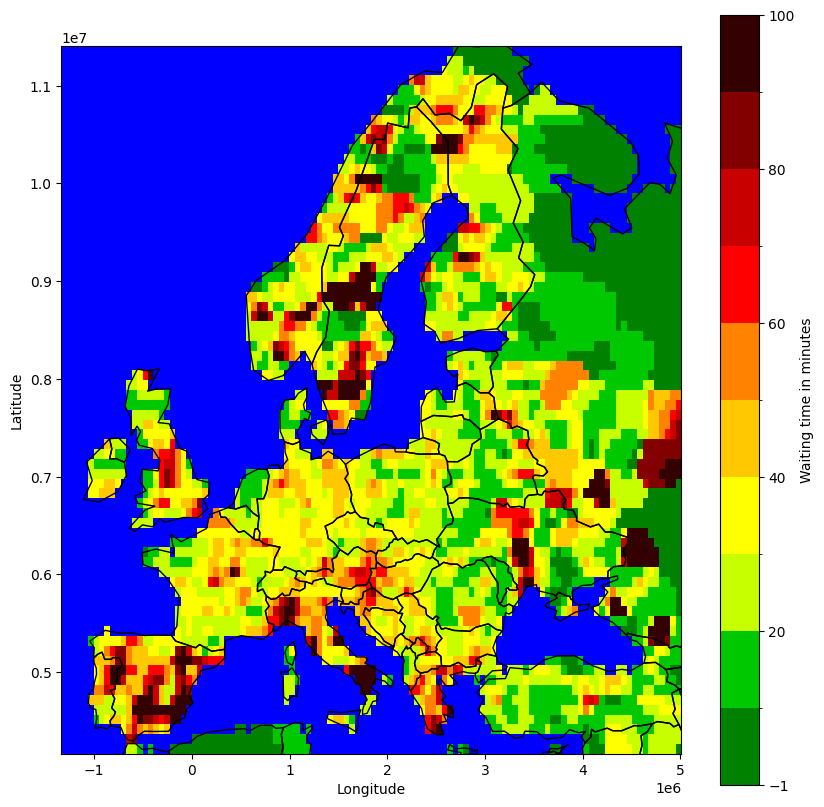

<Figure size 640x480 with 0 Axes>

In [ ]:
wag_model = WeightedAveragedGaussian(region=region)
wag_model = evaluate_cv(estimator=wag_model, X=points[["lon", "lat"]].values, y=points["wait"])
wag_model.build_map()

Cross-validated averaged metrics...
Training RMSE: 61.11639804599442
Training MAE: 30.913483998272994
Validation RMSE: 60.70547568054767
Validation MAE: 30.91486286577797



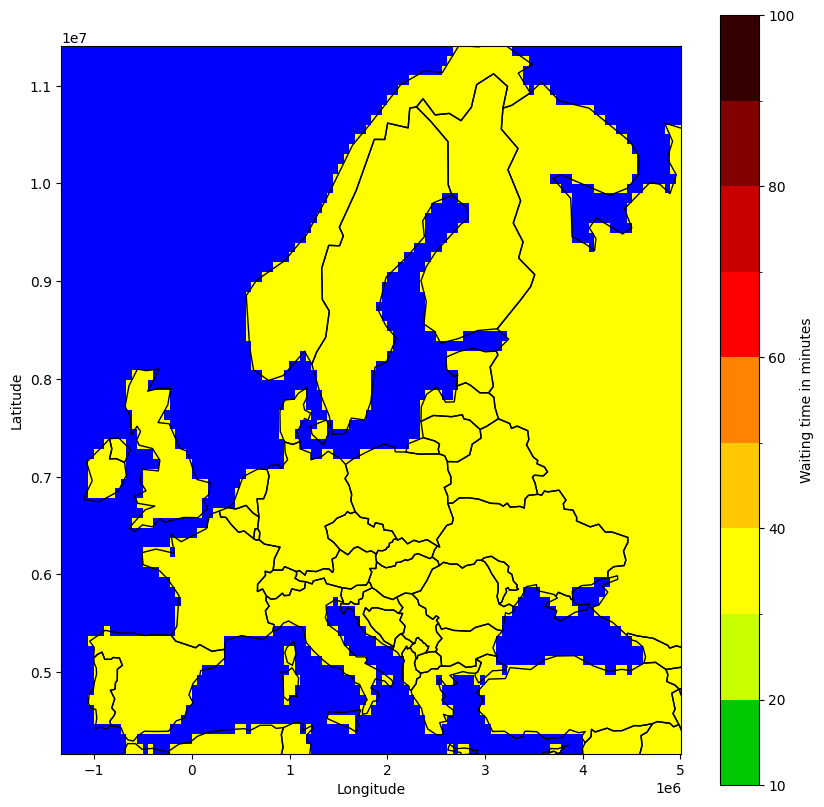

<Figure size 640x480 with 0 Axes>

In [ ]:
average_model = Average()
average_model = evaluate_cv(estimator=average_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(average_model, region=region)

Cross-validated averaged metrics...
Training RMSE: 58.11791055249309
Training MAE: 29.22543932667687
Validation RMSE: 62.324753197056225
Validation MAE: 30.53439666357476



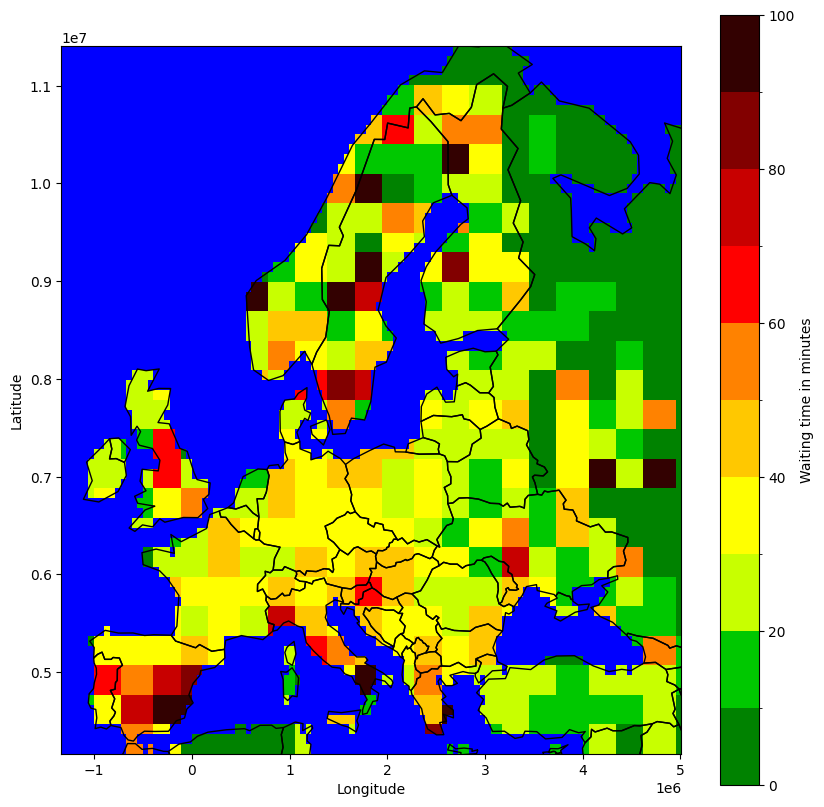

<Figure size 640x480 with 0 Axes>

In [ ]:
tiles_model = Tiles(region=region)
tiles_model = evaluate_cv(estimator=tiles_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(tiles_model, region=region)

Training RMSE: 62.539524119350205
Training MAE 25.62841566972818
Validation RMSE: 62.40334473943454
Validation MAE 26.346785205458573

0.473**2 * RBF(length_scale=6e+05) + WhiteKernel(noise_level=0.952)


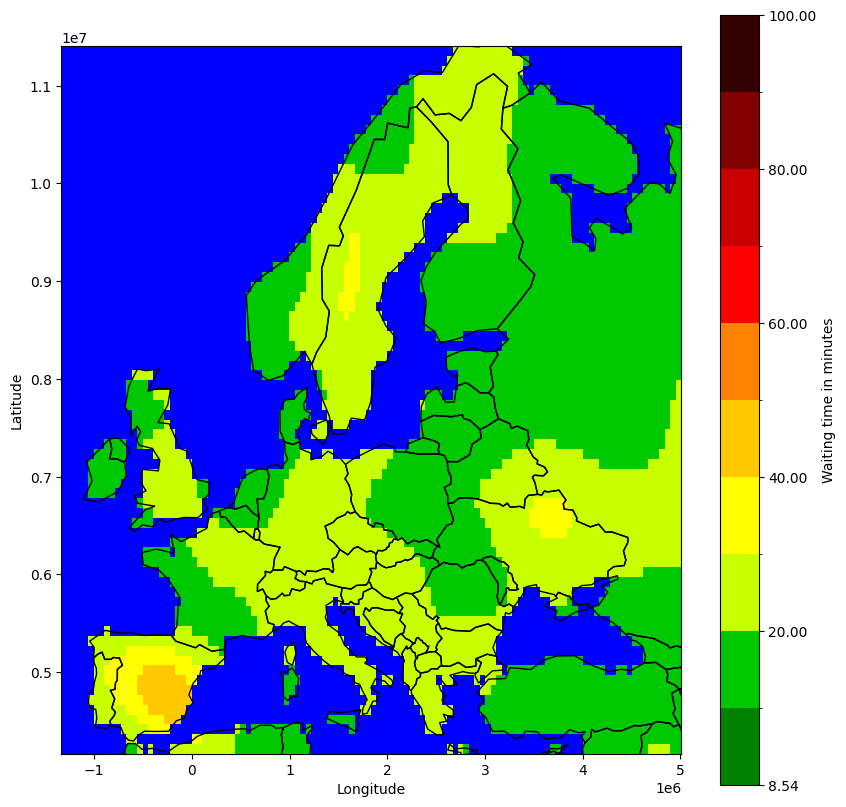

<Figure size 640x480 with 0 Axes>

In [ ]:
X = training[['lon', 'lat']].values
y = training['wait'].values

kernel = ConstantKernel(constant_value=1.0**2, constant_value_bounds=(1e-1, 1e1)) * RBF(
    length_scale_bounds=(6e5, 1e6)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


gpr = get_optimized_gpr(kernel, X, y)
evaluate(gpr, train=training, validation=validation)
print(gpr.regressor_.kernel_)
map_from_model(gpr, region=region)

## Global level

In [18]:
region = 'world'
_, training, validation = get_from_region(region=region)

Training RMSE: 54.49211516262928
Training MAE 26.254153537979786
Validation RMSE: 73.63067045066852
Validation MAE 32.18041202866995



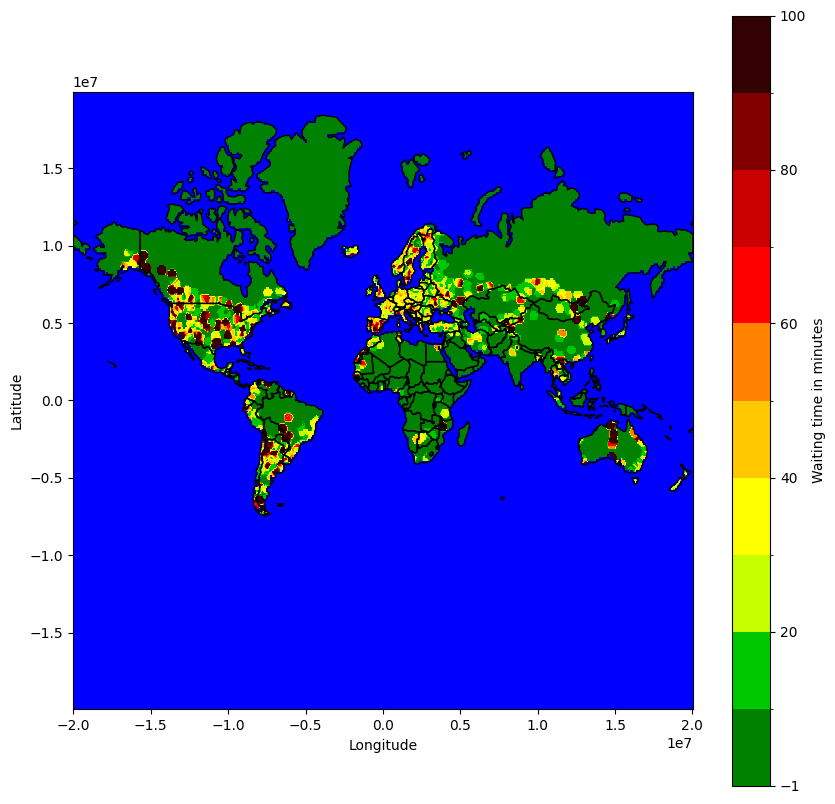

<Figure size 640x480 with 0 Axes>

In [ ]:
wag_model = WeightedAveragedGaussian(region=region)
wag_model.fit(training[['lon', 'lat']].values, training['wait'])
evaluate(wag_model, train=training, validation=validation)
wag_model.build_map()

Training RMSE: 66.2742359915599
Training MAE 32.27671513271487
Validation RMSE: 70.76266325018962
Validation MAE 32.954505812623935



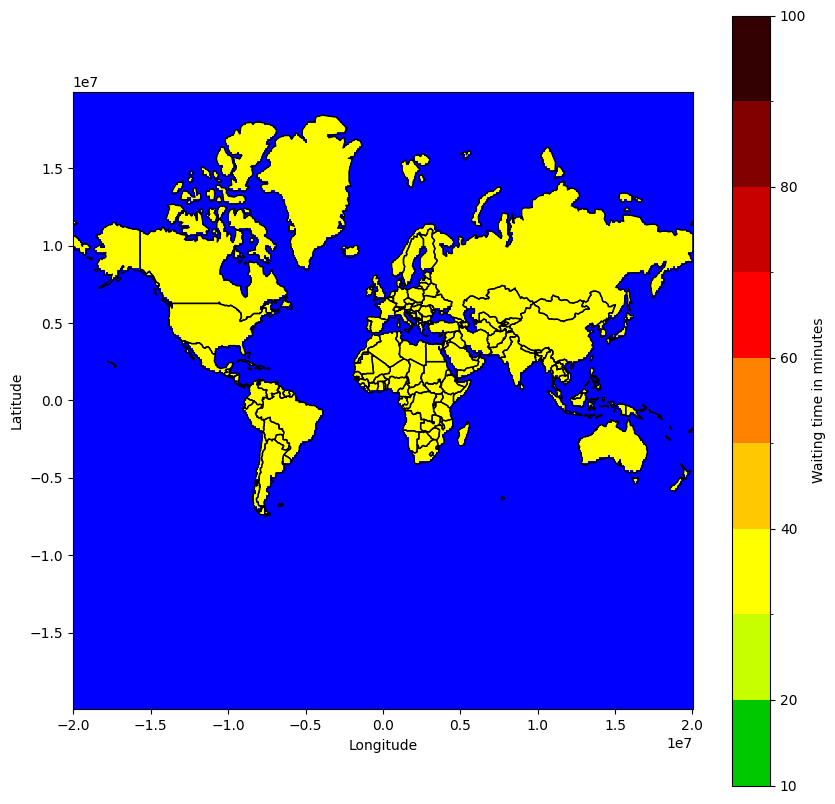

<Figure size 640x480 with 0 Axes>

In [ ]:
average_model = Average()
average_model.fit(training[['lon', 'lat']].values, training['wait'])
evaluate(average_model, train=training, validation=validation)
map_from_model(average_model, region=region)

Training RMSE: 58.53111735808039
Training MAE 28.43296853857368
Validation RMSE: 71.67583236040069
Validation MAE 31.927694623464994



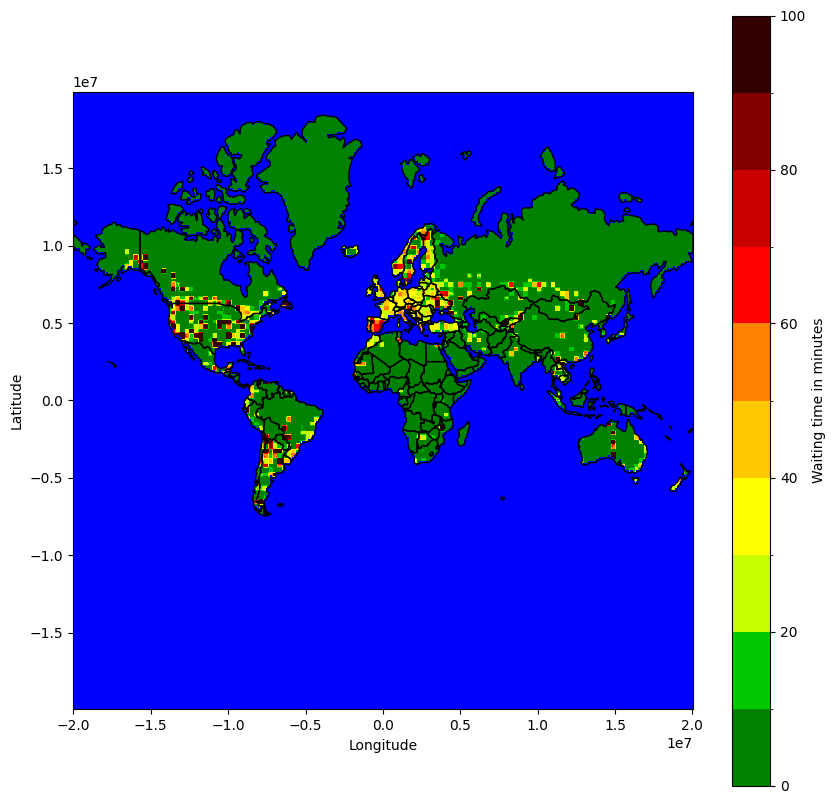

<Figure size 640x480 with 0 Axes>

In [ ]:
tiles_model = Tiles(region=region)
tiles_model.fit(training[['lon', 'lat']].values, training['wait'])
evaluate(tiles_model, train=training, validation=validation)
map_from_model(tiles_model, region=region)

Training RMSE: 66.05334480633411
Training MAE 25.24097549848322
Validation RMSE: 72.04696255559789
Validation MAE 27.299605307530562

0.38**2 * RBF(length_scale=5.74e+04) + WhiteKernel(noise_level=0.856)


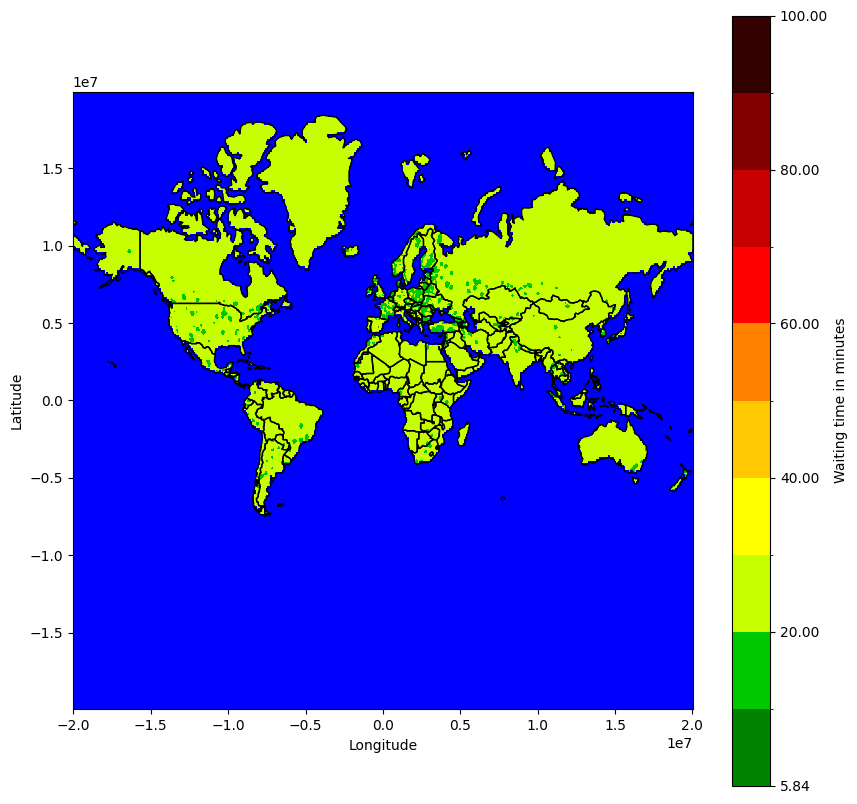

<Figure size 640x480 with 0 Axes>

In [19]:
X = training[['lon', 'lat']].values
y = training['wait'].values

kernel = ConstantKernel(constant_value=1.0**2, constant_value_bounds=(1e-1,1e1)) * RBF(
    length_scale_bounds=(1e4, 1e6)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


gpr = get_optimized_gpr(kernel, X, y)
evaluate(gpr, train=training, validation=validation)
print(gpr.regressor_.kernel_)
map_from_model(gpr, region=region)

# Tweaking the Gaussian process

On all three maps the learning GP model shows better performance than the other three naive models regarding MAE. Thus it seems to be worth it to further develop and improve the GP. In addition the maps built by the GP strongly fullfil our visual requirements.

So far we modelled the GP so that the RBF lengthscale is the same in longitude and latitude direction. We believe that this is a reasonable choice as there is no obvious reason why a single data point should influenc one direction more than the other. Still there might be broad (non-obvious) structures in the way land mass is shaped or highways are built that could favor one of the directions. Below we can observe that accoding to the models data points have a stronger influence in the north-south-direction than in the east-west-direction.

GERMANY


Training RMSE: 43.571016891835875
Training MAE 20.849118559667964
Validation RMSE: 35.189596788586606
Validation MAE 18.917425159087657

0.346**2 * RBF(length_scale=[4.93e+04, 4.67e+04]) + WhiteKernel(noise_level=0.848)


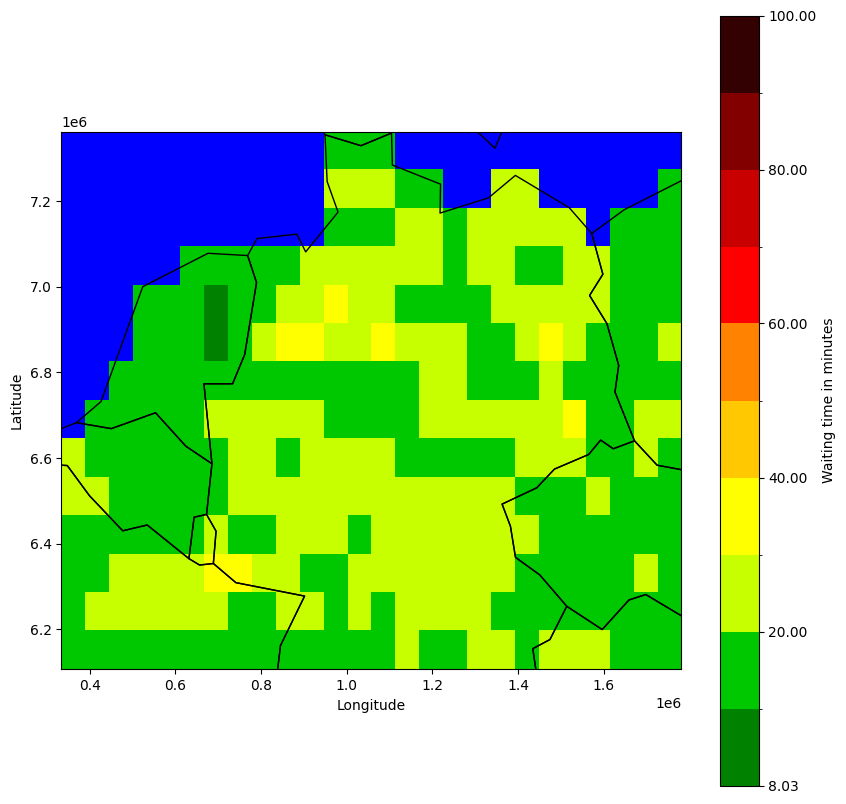

EUROPE
Training RMSE: 61.034386656237395
Training MAE 24.178212206202836
Validation RMSE: 61.88089172962197
Validation MAE 26.071018128789582

0.367**2 * RBF(length_scale=[5.68e+04, 4.41e+04]) + WhiteKernel(noise_level=0.858)


<Figure size 640x480 with 0 Axes>

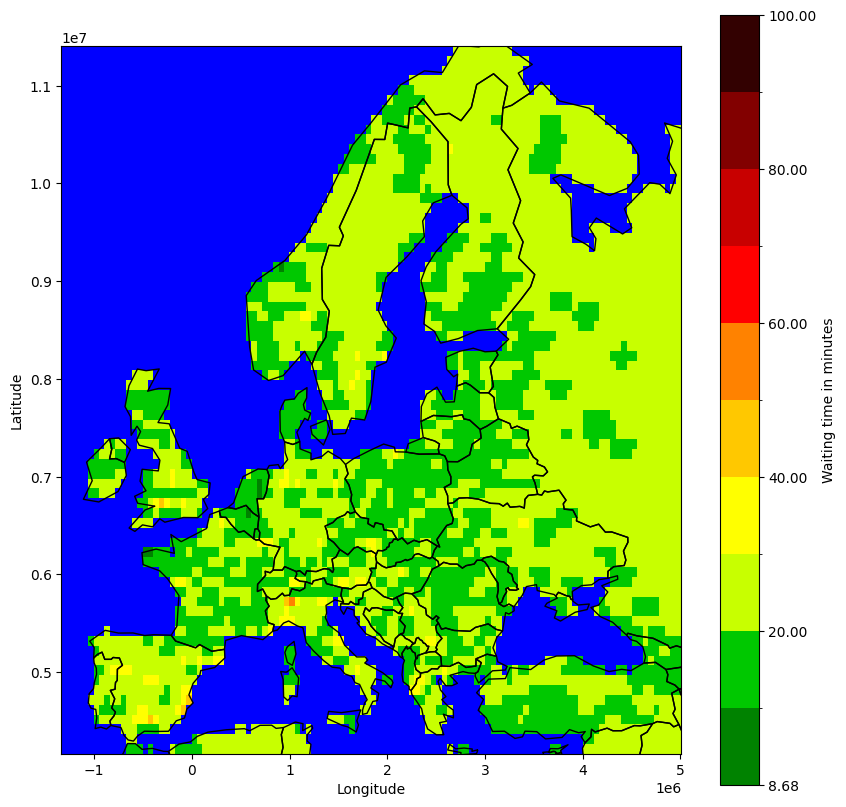

WORLD
Training RMSE: 66.02788963846761
Training MAE 25.221515370926657
Validation RMSE: 72.04556879396291
Validation MAE 27.314467866083085

0.382**2 * RBF(length_scale=[6.57e+04, 4.89e+04]) + WhiteKernel(noise_level=0.855)


<Figure size 640x480 with 0 Axes>

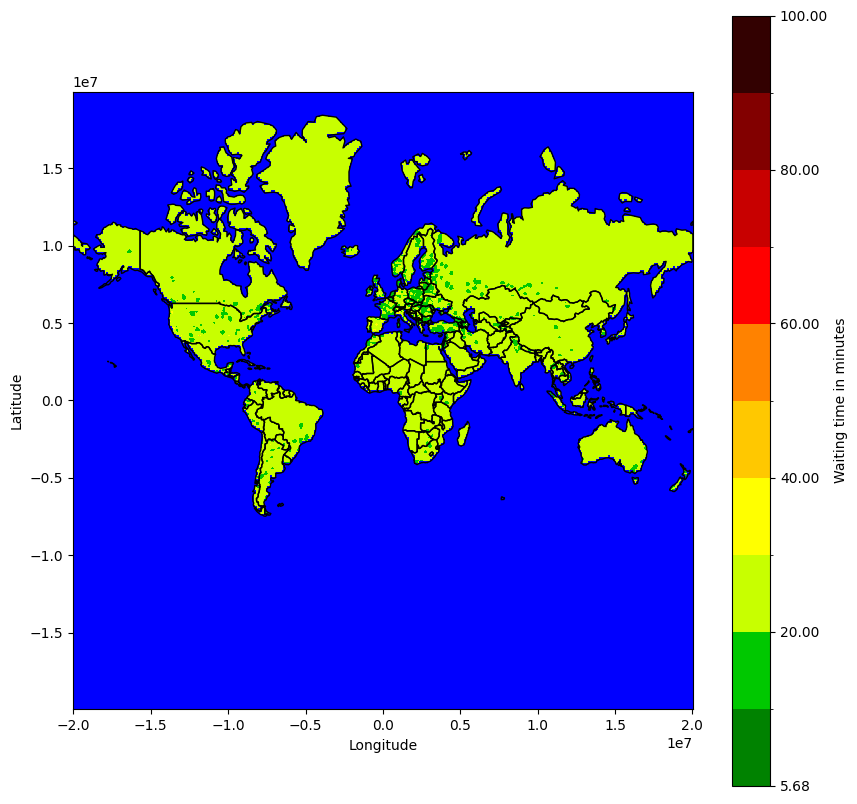

<Figure size 640x480 with 0 Axes>

In [ ]:
regions = ['germany', 'europe', 'world']
for region in regions:
    print(region.upper())
    _, training, validation = get_from_region(region=region)

    X = training[["lon", "lat"]].values
    y = training["wait"].values

    kernel = ConstantKernel(constant_value=1.0**2, constant_value_bounds=(1e-1,1e1)) * RBF(
        length_scale=[1e5, 1e5],
        length_scale_bounds=[(1e4, 1e6), (1e4, 1e6)],
    ) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


    gpr = get_optimized_gpr(kernel, X, y)
    evaluate(gpr, train=training, validation=validation)
    print(gpr.regressor_.kernel_)
    map_from_model(gpr, region=region)

Through the maps on differently-sized regions we could observe that RBF lengthscales became larger with broader maps. Thus we can assume that there are different levels on which a similar attitude towards hitchhiking exists for example on a regional, state on country level. This is also what we can report from experience.

As we can see the regional differences we observe in the map of Germany are no longer visible on the other maps. To mitigate this effect and to incorporate those findings into our model we have to allow it to choose and mix different lengthscales. One way to achieve this is to use multiple RBFs in the kernel by summing them up. Let us use three RBFs as an rather arbitrary choice for now.

Now the variance parameter (factor in front of the squared exponential kernel) fulfills the important function to weight (mix) the RBFs with different lengthscale differently. If the variance was fixed the optized model would likely have the same lengthscale for each RBF. Another measure we are applying to prevent same lengthscales is to define non-overlapping lengthscale-bounds for the three RBFs thus hopefully getting a small, medium and large lengthscale. We are choosing narrower variance bounds for the RBF with the smallest lengthscale as allowing short lengthscales and high variance often results in overfitting to the data which we want to prevent.

EUROPE
Training RMSE: 61.08354747444816
Training MAE 24.263645261367014
Validation RMSE: 61.78478669271275
Validation MAE 25.960823962073686

0.31**2 * RBF(length_scale=[5e+04, 5e+04]) + 0.161**2 * RBF(length_scale=[1.82e+05, 2.93e+05]) + 0.16**2 * RBF(length_scale=[5e+05, 5.73e+05]) + WhiteKernel(noise_level=0.862)


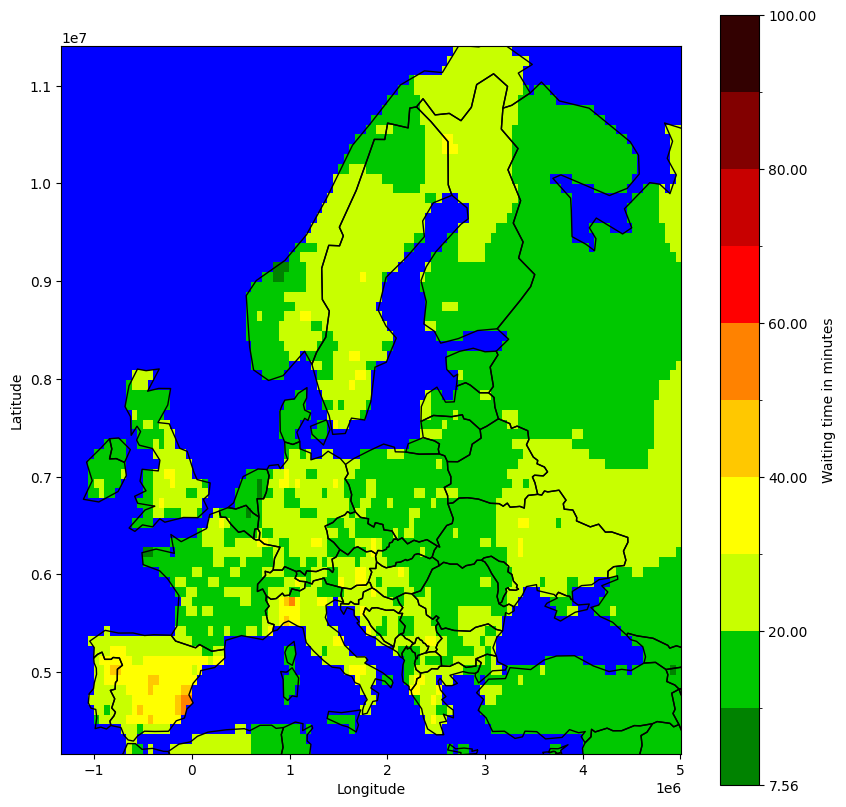

WORLD
Training RMSE: 65.69526143123765
Training MAE 25.14789007948823
Validation RMSE: 71.71019377491955
Validation MAE 27.159121145361606

0.311**2 * RBF(length_scale=[5e+04, 5e+04]) + 0.166**2 * RBF(length_scale=[1.84e+05, 2.78e+05]) + 0.295**2 * RBF(length_scale=[8e+05, 8e+05]) + WhiteKernel(noise_level=0.848)


<Figure size 640x480 with 0 Axes>

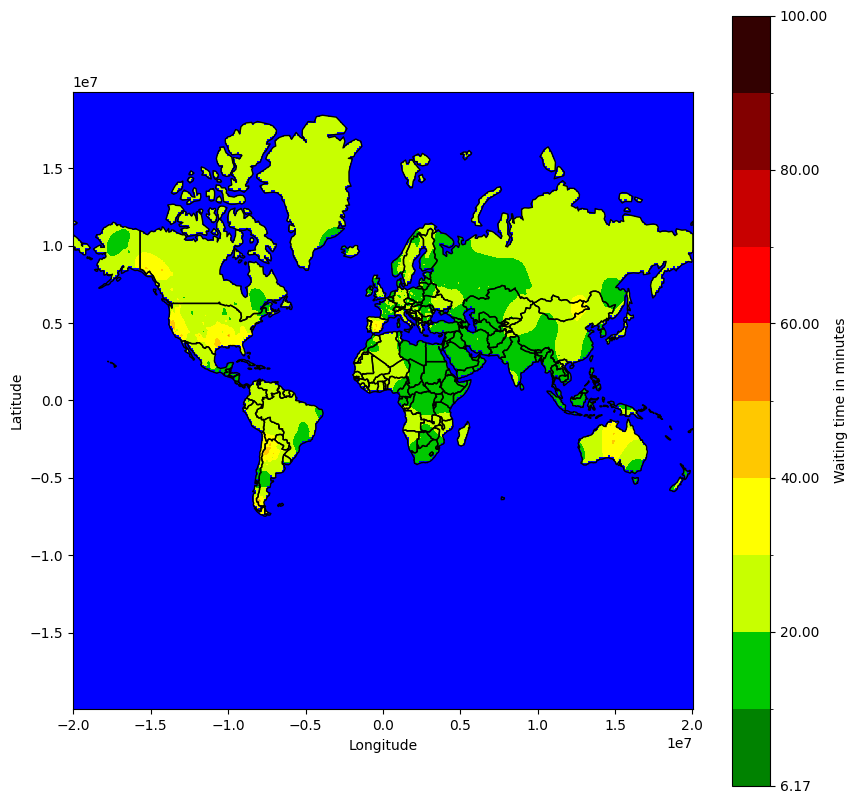

<Figure size 640x480 with 0 Axes>

In [ ]:
regions = ['europe', 'world']
for region in regions:
    print(region.upper())
    _, training, validation = get_from_region(region=region)

    X = training[["lon", "lat"]].values
    y = training["wait"].values
    
    sigma = 1.0

    rbf = RBF(
        length_scale=[5e4, 5e4], length_scale_bounds=(5e4, 1e5)
    )
    rbf2 = RBF(
        length_scale=[1e5, 1e5], length_scale_bounds=(1e5, 5e5)
    )
    rbf3 = RBF(
        length_scale=[5e5, 5e5], length_scale_bounds=(5e5, 8e5)
    )

    kernel = (
        ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e1)) * rbf
        + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf2
        + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf3
        + WhiteKernel(noise_level=1.05e0, noise_level_bounds=(1e-1, 1e1))
    )

    gpr = get_optimized_gpr(kernel, X, y)
    evaluate(gpr, train=training, validation=validation)
    print(gpr.regressor_.kernel_)
    map_from_model(gpr, region=region)

# Saving our currently best model and training on all available data


In [ ]:
points, training, validation = get_from_region(region='world')

X = points[["lon", "lat"]].values
y = points["wait"].values

sigma = 1.0

rbf = RBF(
    length_scale=[5e4, 5e4], length_scale_bounds=(5e4, 1e5)
)
rbf2 = RBF(
    length_scale=[1e5, 1e5], length_scale_bounds=(1e5, 5e5)
)
rbf3 = RBF(
    length_scale=[5e5, 5e5], length_scale_bounds=(5e5, 8e5)
)

kernel = (
    ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e1)) * rbf
    + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf2
    + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf3
    + WhiteKernel(noise_level=1.05e0, noise_level_bounds=(1e-1, 1e1))
)

gpr = get_optimized_gpr(kernel, X, y)

# save the final global model
with open("models/best_gp.pkl", "wb") as file:
    pickle.dump(gpr, file)

# Exploiting the probabilistic approach

Eventually we can turn towards one of the reasons we applied a probabilistic model such as the GP in the first place. Alongside the mean of the predictive distribution (the function we are using to make predictions) it gives us uncertainties about the predictions via the standard deviations of the predictive distribution. Those are especially handy when we communicate the results of this work via a map to also convey that predictions made in certain area of the world are uncertain because of a lack of training data in that region and thus should not be trusted.

100%|██████████| 720/720 [25:32<00:00,  2.13s/it]


Loading country shapes...
Transforming heatmap...
max map waiting time: 76.52209065340682
min map waiting time: 4.991107912117773
Plotting heatmap...
max waiting time: 675


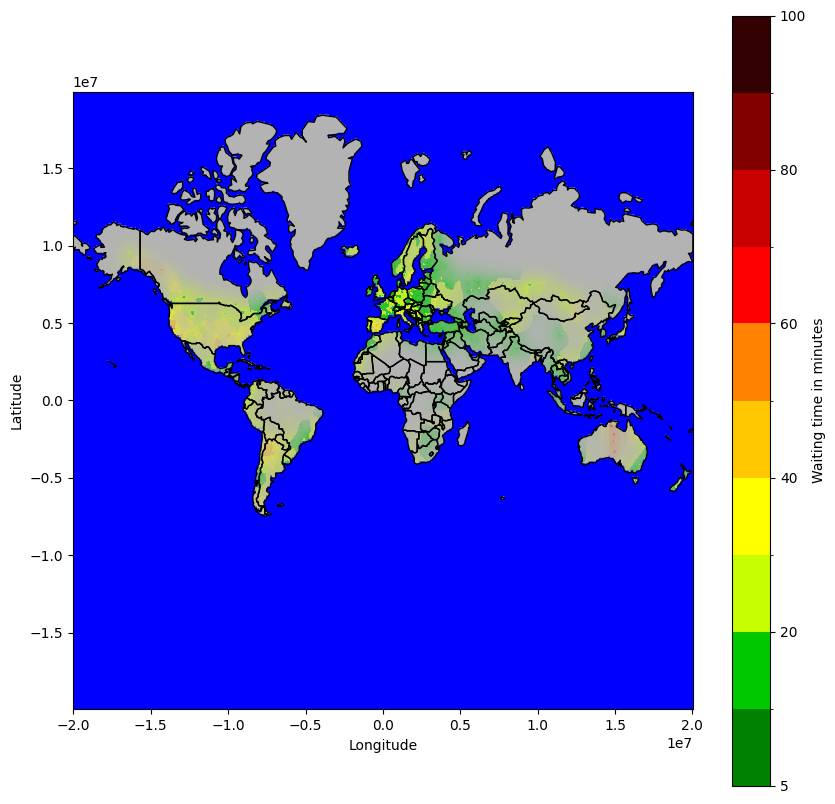

<Figure size 640x480 with 0 Axes>

In [ ]:
with open("models/best_gp.pkl", "rb") as file:
    gpr = pickle.load(file)

map_from_model(gpr, region='world', show_uncertainties=True, verbose=True)

# Further ideas and work


There are a few ideas how all this could be developed further.

1. As stated in the beginning there is measurement and outlier noise in the data. So far we did not model measurement noise specifically. An idea would be to assume that measurement noise increases with waiting time. One might be able to learn a function that represents this kind of noise. Giving an example one might assume that for a recorded waiting time of 5min it only deviates from the real waiting time whereas for 4h there is a 30min deviation.

2. Combining multiple RBF functions in one kernel is a quite simple way to model a variety of lengthscales. Being more sophisticated one could apply multiple rational quadratic kernels instead as this kernel models a distribution over lengthscales.

3. Applying the log-transformation to the data before applying the GP allowed us to never get negative predictions. On the other end one might not want to get predictions larger than the longest recorded waiting time and thus constrain the upper bound as well. For example this could be achieved by applying a probit-transformation. However we did not see that too large predictions were a problem so far.

4. As training a GP on a large dataset such as for the whole world takes some time we could not search further over the parameters of our final model although one ideally would not want to end up with parameter values at the interval bounds as it shows that the model is not optimal. For optimization and finding local optima one could have a look at [Bayesian optimization](https://distill.pub/2020/bayesian-optimization/).

5. On could go beyond longitude and latitude as features for each data points e.g. also taking the date or day of the week into account. We are afraid we do not have enough data at the moment to build meaningful models that way.

6. Finding a more suitable initial distribution than log-normal of the data. Currently the correcy inverse transformation does not yield good results (thus we modified it). Could check numeric_transformer.get_transformer_with_least_skew() for this.

7. Curretly  we are not conciously tackling any biases related to that people only hitchhike in regions where they know it works, that we have no data of unsuccessful rides and that most recorded hikes are contributed by people with a positive attitude towards their hitchhiking experience and frequent hitchhikers and thus likely lower waiting times

# More GP resources I liked

- https://distill.pub/2019/visual-exploration-gaussian-processes/
- https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.03-Gaussian-Process-Regression.html
- https://domino.ai/blog/fitting-gaussian-process-models-python
- https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py